# Results / Report
#### Dedicated purely to the most interesting results. Comprehensive overview of my findings and inferences
For a full breakdown of my thought & analysis process, visit `exploration.ipynb`

---

# Abstract

In [1]:
from data.render import DataRenderer
from data.load import DataLoader
from data.api import SpotifyAPI

In [2]:
api = SpotifyAPI()
loader = DataLoader()
renderer = DataRenderer()

df_aoty = loader.load_aoty()
df_top100s = loader.load_top100s()

---

## ~ How to make a chart-topper, according to characteristics of the Spotify Top 100
*The Spotify Top 100 is an ordered ranking of the top 100 most streamed songs ever on Spotify. In this section, we observe the statistically significant characteristics & metadata of each individual song: more specifically, the 'energy', tempo, genre, and 'acousticness' metrics*

### 1.1 Energy
*Spotify defines energy as the single-value representation of a song's "dynamic range, perceived loudness, timbre, onset rate, and general entropy" (2)*

Initial hypothesis: High-energy tracks perform typically perform better than its low-energy counterparts, so we will see a larger proportion of the Spotify Top 100 occupied by songs with a higher energy metric ($\geq 50$)

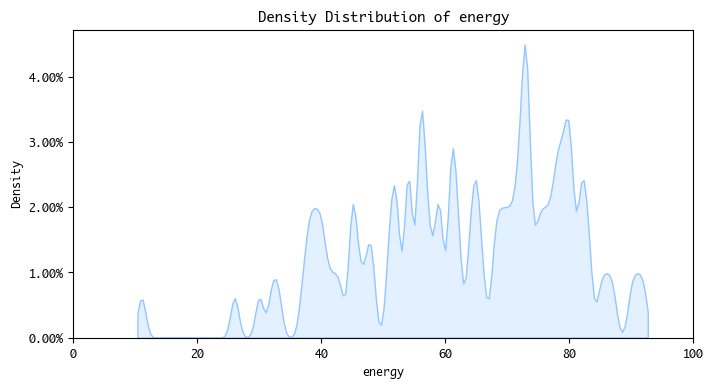

In [3]:
renderer.plot_density(df_top100s, 'energy')

In [4]:
energy = loader.get_col(df_top100s, 'energy')
str(energy.mean()), str(energy.median()), str(energy.std())

('62.68', '64.5', '16.491736528861168')

Results: Most of the Spotify Top 100 consists of high energy music. Because we don't have access to Spotify's specific metric calculations, we can either assume that the energy metric is generally overcalculated or our original hypothesis was correct. We expand on this idea in the next section.

### 1.2 BPM (Beats per Minute)
*Beats per minute is the number of 'beats' in a song that pass every minute. It's a measure of tempo and a higher bpm generally indicates a faster song (with some exceptions, which I will cover in the results). Note that Spotify makes this calculation; this metadata is typically NOT provided by the artist*

Initial hypothesis: Because energy is generally high, I expect a high average BPM because faster songs are generally correlated with energy (although keep in mind that Spotify factors in several components to its energy metric, and tempo is not explicitly labeled as one of them. However, a song with higher tempo may suggest that it has more or less dynamic range, for example).

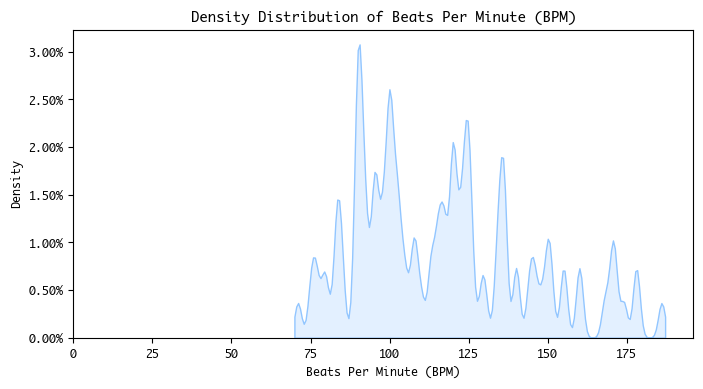

In [5]:
# scaled=False because BPM does not range absolutely from 0 to 100, so the graph observes all BPMs in the Spotify Top 100
renderer.plot_density(df_top100s, 'beats.per.minute', "Beats Per Minute (BPM)", scaled=False)

In [6]:
bpm = loader.get_col(df_top100s, 'beats.per.minute')
str(bpm.mean()), str(bpm.median()), str(bpm.std())

('116.97', '115.0', '27.470628943390697')

Results: Most of the BPM ranges between 90 and 143 BPM. Compared to songs not on the Top 100, this is normal speed and nothing unordinary. We can interpret this in a few ways: the energy metric might be overcalculated, tempo might not have as much of an influence on the energy metric as expected, or some values are being misrepresented.

To expand on the idea of 'misrepresented' BPMs, recall that Spotify makes this calculation. Therefore, because we don't have information on how Spotify calculates BPM, it is a **very real possibility** that some BPMs are being represented in half-time or double-time: that is, a song in 160 BPM can be 80 BPM per Spotify's algorithm, or vice versa *(4)*

With all things considered, at the moment we can only say that (according to Spotify) high energy tracks tend to chart higher, but BPM does not necessarily matter for this metric. Most Top 100 entries sit around 100 BPM, but this may be by coincidence considering this is a popular BPM range for most songs, not just chart-toppers.

### 2.1 Genre

*While artists **can** input genre when uploading music to Spotify, generally speaking Spotify assigns genre using machine learning algorithms. This is so that all songs are marked with a genre & can be properly placed into curated playlists (5)*

Initial hypothesis: We will see only a handful of genres dominate the charts; genre diversity will be practically nonexistent. Pop is a likely contender.

In [7]:
genres_patterns = {
    "Pop": 'pop',
    "Rock": 'rock|band',
    "Hip-Hop": 'rap|hip',
    "Electronic": 'electro',
    "R&B": 'r&b|soul|rnb',
    "Country": 'country',
    "Jazz": 'jazz',
    "Classical": 'classical',
    "Blues": 'blues',
    "World/Folk": 'world|folk',
    "Reggae": 'reggae',
    "Dance": 'dance',
    "Experimental": 'experimental',
    "Indie/Alt": 'indie|alt|singer-songwriter',
}

In [8]:
def classify(df, column: str, pattern: str):
    return loader.filter(df, column, pattern, contains=True)

We utilize these genre 'buckets' and a helper function `classify` to simplify Spotify's genre classification algorithm. This is to ensure all subgenres are properly represented. Note that some genres will fall into two buckets: for example, 'pop rap' will fall into both 'pop' and 'hip-hop'.

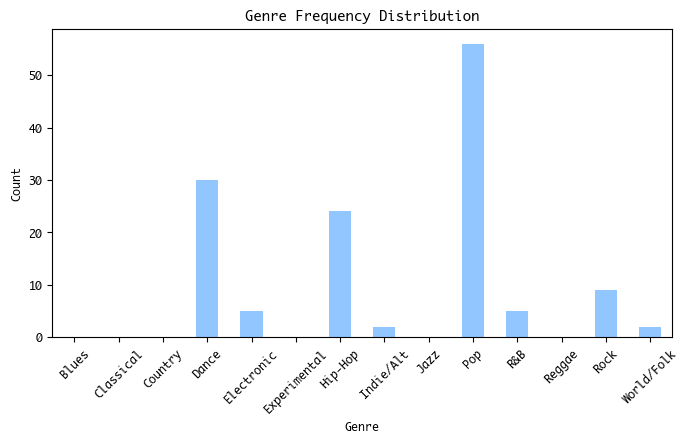

In [9]:
genres = {genre: classify(df_top100s, 'top genre', pattern) for genre, pattern in genres_patterns.items()}
renderer.plot_key_frequency(genres, title = 'Genre')

Observe that Pop, Dance, and Hip-Hop clearly dominate the Spotify Top 100 chart. More on this in a bit.

### 2.2 Acousticness
*Acousticness is a metric that measures "whether the track is acoustic. [100] represents high confidence the track is acoustic." (2)*

The reason I introduce acousticness is we can get a clearer picture of what exactly it means for pop, dance, and hip-hop to dominate the chart. i.e. what about these genres gives its popularity? Since we've already observed tempo, we observe acouticness to see if this correlates with why predominantly acoustic/analog music (Blues, Classical, Jazz) are absent from the Top 100.

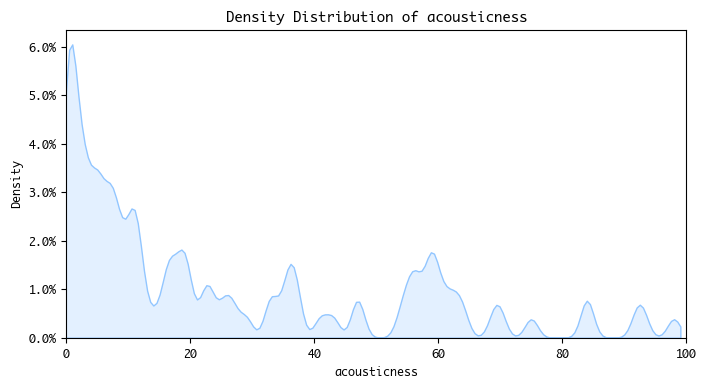

In [10]:
renderer.plot_density(df_top100s, 'acousticness')

From this image, it's clear that songs with a low acousticness score (i.e. a VERY low confidence that the song is acoustic, or conversely a high confidence that the song is digital) dominate the charts. Pop, hip-hop, and dance music are all electronic nowadays. This could be for a variety of reasons- a main one being that digital sounds are generally easier to work with as musicians (they are shareable, accessible, and easier to process). You could also make the case that the accessibility of digital sounds makes it easier to produce higher quality work- therefore, people on Spotify tend to appreciate digital music more. Either way, it seems that consumers are growing more accustomed to digital music as a whole, and Pop/Hip-Hop/Dance are at the forefront of this development.

---

## ~ Does Critical Opinion Influence Chart Positioning?

*We source our critical opinions from AOTY (6). In this section, we intend to demonstrate disparities or similarities between chart rankings & critical opinion. The intent is to observe if it's more important to satisfy the masses or to satisfy critics, and if critics are a good signal of a song's charting potential.*

### 1.1 Case Studies in Album Rankings

*We present a couple case studies to show similarities/disparities in how critics/spotify users view an artist's album discography*

Initial hypothesis: Critics' album rankings won't agree with the public's. Oftentimes crtics are looking for something different than consumers when reviewing music. A lot of modern music doesn't have substance and in personal experience, critics crave this.

In [11]:
def comparison(artist: str):
    # First, grab all Kendrick Lamar albums of interest from AOTY
    albums_spotify = loader.filter(df_aoty, 'artist', artist).copy()

    ### Spotify Top 100s
    # Next, get the popularity of each album from the Spotify API
    albums_spotify.loc[:, 'popularity'] = albums_spotify['title'].apply(lambda x: api.get_popularity(x))
    # Sort the albums by popularity
    albums_spotify = albums_spotify.sort_values(by='popularity', ascending=False).reset_index(drop=True)
    # Add a column for the relative rank of each album
    albums_spotify.insert(0, 'relative_rank', range(1, len(albums_spotify)+1))

    ### AOTY Rankings
    # Retrieve all fields and append a custom rank column & the user score column
    albums_aoty = loader.get_col(albums_spotify, 'title').T.to_frame()
    ratings = loader.get_col(albums_spotify, 'user_score').T.to_frame()
    albums_aoty.insert(1, 'user_score', ratings)
    albums_aoty.sort_values(by='user_score', ascending=False, inplace=True)
    albums_aoty.insert(0, 'relative_rank', range(1, len(albums_aoty) + 1))


    # Ensure Spotify Top 100 songs is formatted for comparison
    albums_spotify = albums_spotify[['relative_rank', 'title', 'popularity']]
    return albums_spotify, albums_aoty

    

We use this helper function to help us with comparisons. All it does it load the relevant artist's albums from Spotify API and AOTY. We sort the Spotify entries by the 'popularity' metric (a single-value metric that considers both the quantity of streams AND how recent they are). We sort the AOTY entries by the 'user_score' metric (an aggregated score of reviews from thousands of users/critics on AOTY). Then I append the relative rank for easy comparison.

In [12]:
data = comparison('Kendrick Lamar')
renderer.split_show(data[0], data[1], "Spotify Top 100", "AOTY")

relative_rank,title,popularity
1,DAMN.,88
2,Mr. Morale & The Big Steppers,83
3,To Pimp a Butterfly,80
4,Section.80,74
5,"good kid, m.A.A.d city",49
relative_rank,title,user_score
1,To Pimp a Butterfly,95
2,"good kid, m.A.A.d city",94
3,Mr. Morale & The Big Steppers,86
4,DAMN.,84


Observe that for Kendrick Lamar, there is a large disparity between rankings (a special case: GKMC is 5th in the Spotify 100, but 2nd in AOTY)

In [13]:
data = comparison('Taylor Swift')
renderer.split_show(data[0], data[1], "Spotify Top 100", "AOTY")

relative_rank,title,popularity
1,Red (Taylor's Version),86
2,Red,86
3,Speak Now (Taylor's Version),84
4,Speak Now,84
5,evermore,80
6,folklore,78
7,1989,77
8,folklore: the long pond studio sessions (from the Disney+ special),68
relative_rank,title,user_score
1,folklore: the long pond studio sessions (from the Disney+ special),83


Another large disparity! Taylor Swift has an album slotted in #8 for relative chart rankings, but AOTY places it at #1.

In [23]:
data = comparison('Daft Punk')
renderer.split_show(data[0], data[1], "Spotify Top 100", "AOTY")

relative_rank,title,popularity
1,Discovery,78
2,Random Access Memories,77
3,Homework,68
relative_rank,title,user_score
1,Discovery,91
2,Random Access Memories,86
3,Homework,77


Sometimes, the charts do agree as well.

---

## ~ The best time to release music & the immense growth of the streaming era
*For this section, we observe the Spotify Top 100 to quantify how streaming is evolving. The intent is to see if releasing music is still a good idea, if the sole intent is to chart-top (and replace songs that have been there for years). Note that dating is important for this section: the dataset only covers data up to a bit into 2021*

### 1.1 Spotify's platform growth & its impact on Top 100 chart entries

*We know that Spotify gains hundreds of millions of monthly active users every year. This is public data. However, how many of these users actually influence change in the charts? If I wanted to make a hit, would they be helpful to me, or are they just streaming the most popular music? We intend to answer this question in this section. (9)*

Initial hypothesis: Spotify is growing every year, but new chart entries are slowing down- that is, big names with billions of streams have solidified theirselves in the charts and will not fall out anytime in the near future.

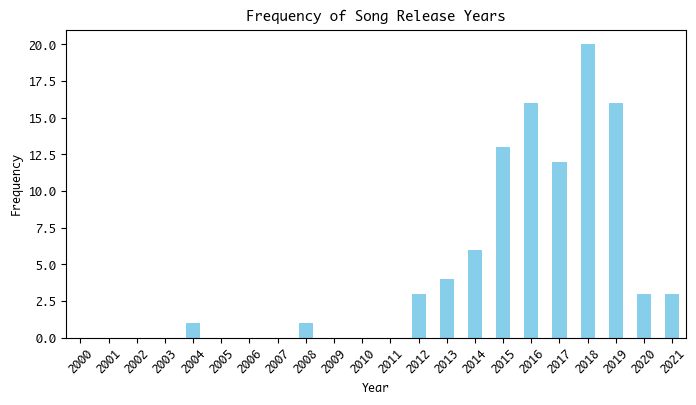

In [25]:
renderer.plot_year_frequency(df_top100s, "year", range(2000, 2022) )